In [1]:
import fiona, utm, os, re
import datetime
import rasterio
import pandas as pd
from rasterio.mask import mask
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fields = {}
field_names = ['20', '21', '22', '23', '17', '18']
for field_name in field_names:
    with fiona.open('/Users/vasilii/Desktop/research/rostov/rassvetQGIS.GEOJSON', 'r') as shapefile:
        fields[field_name] = [feature['geometry'] for feature in shapefile
                              if feature['properties']['name'] == field_name]
        
for field_name in field_names:
    for field in fields[field_name]:
        if field['type']=='Polygon':
            field['coordinates'] = [[utm.from_latlon(i[1], i[0])[:2] for i in field['coordinates'][0]]]
        else:
            geoms = []
            for geom in field['coordinates']:
                geoms.append([[utm.from_latlon(i[1], i[0])[:2] for i in geom[0]]])
            field['coordinates'] = geoms

In [3]:
ndvis = {}
for field_name in field_names:
    ndvis[field_name] = {}

# Sentinel 2

In [7]:
root = '/Users/vasilii/Desktop/sentinel/'
for folder in tqdm(next(os.walk(root))[1]):
    date = re.findall('(\d+)T', folder)[-1]
    for granule in next(os.walk(root+folder+'/GRANULE'))[1]:
        if 'T37TFM' in granule:
            for image in next(os.walk(root+folder+'/GRANULE/'+granule+'/IMG_DATA'))[2]:
                if '_B04.jp2' in image and 'aux.xml' not in image:
                    band_04 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
                elif '_B08.jp2' in image and 'aux.xml' not in image:
                    band_08 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
    
    for field_name in field_names:
        masked_04 = mask(band_04, fields[field_name], nodata=0, crop=True)
        masked_08 = mask(band_08, fields[field_name], nodata=0, crop=True)

        field_04 = masked_04[0].data[0].astype('int16')
        field_08 = masked_08[0].data[0].astype('int16')

        field_04 = field_04[np.nonzero(field_04)]
        field_08 = field_08[np.nonzero(field_08)]
        
        ndvi = (field_08-field_04)/(field_08+field_04)
        ndvis[field_name][datetime.datetime.strptime(date, '%Y%m%d').date()] = (np.mean(ndvi), np.std(ndvi))
    
    band_04.close()
    band_08.close()

100%|██████████| 39/39 [00:37<00:00,  1.05it/s]


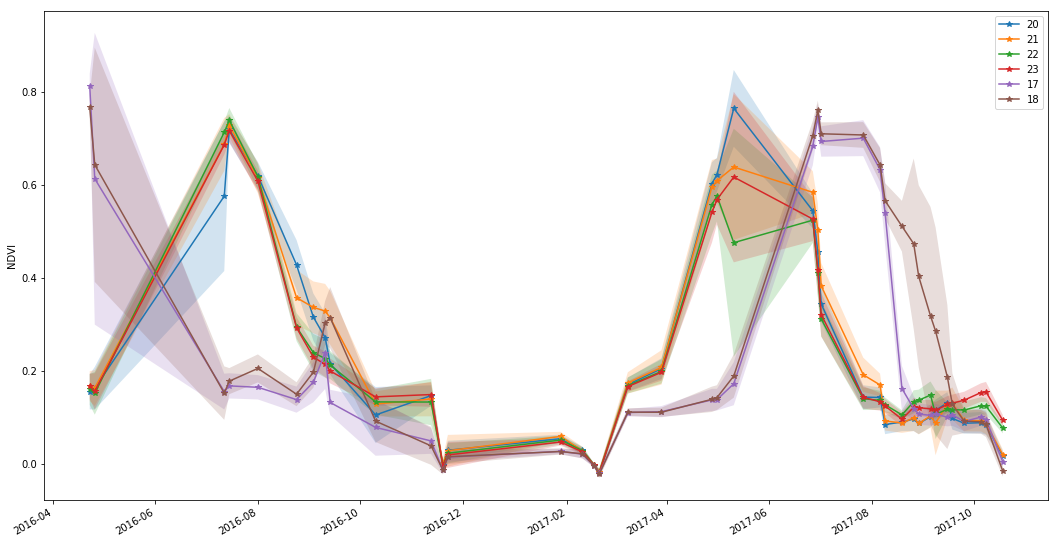

In [14]:
plt.figure(figsize=(18,10))
for field_name in field_names:
    plt.plot(sorted(ndvis[field_name]), [ndvis[field_name][date][0] for date in sorted(ndvis[field_name])],
             '*-', label=field_name)
    plt.fill_between(sorted(ndvis[field_name]), 
                 [ndvis[field_name][date][0]+ndvis[field_name][date][1] for date in sorted(ndvis[field_name])],
                 [ndvis[field_name][date][0]-ndvis[field_name][date][1] for date in sorted(ndvis[field_name])],
                     alpha=0.2)
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel('NDVI')
plt.show()

In [24]:
print('date', end='\t\t')
for field_name in field_names:
    print('Field', field_name, end='\t')
print()
for date in sorted(ndvis[field_name]):
    print(date, end='\t')
    for field_name in field_names:
        print('%.3f' % round(ndvis[field_name][date][0], 3)+'±'+'%.3f' % round(ndvis[field_name][date][1], 3), end='\t')
    print()

date		Field 20	Field 21	Field 22	Field 23	Field 17	Field 18	
2016-04-23	0.156±0.038	0.168±0.032	0.161±0.033	0.168±0.027	0.812±0.027	0.767±0.026	
2016-04-26	0.164±0.046	0.164±0.039	0.153±0.046	0.157±0.039	0.613±0.313	0.644±0.252	
2016-07-12	0.576±0.161	0.687±0.057	0.713±0.023	0.686±0.021	0.156±0.038	0.153±0.057	
2016-07-15	0.719±0.029	0.728±0.024	0.739±0.026	0.717±0.024	0.169±0.027	0.179±0.028	
2016-08-01	0.620±0.030	0.615±0.033	0.618±0.027	0.608±0.022	0.166±0.026	0.206±0.030	
2016-08-24	0.428±0.054	0.358±0.060	0.295±0.030	0.294±0.023	0.139±0.028	0.151±0.026	
2016-09-03	0.316±0.051	0.337±0.056	0.240±0.040	0.230±0.025	0.177±0.043	0.198±0.033	
2016-09-10	0.272±0.052	0.329±0.058	0.227±0.041	0.215±0.027	0.240±0.078	0.304±0.047	
2016-09-13	0.216±0.023	0.315±0.058	0.213±0.030	0.201±0.027	0.133±0.027	0.315±0.066	
2016-10-10	0.106±0.060	0.130±0.027	0.134±0.027	0.145±0.018	0.079±0.061	0.093±0.045	
2016-11-12	0.148±0.022	0.141±0.037	0.134±0.050	0.150±0.026	0.050±0.028	0.040±0.041	
2016-11-19	-0.0

# Landsat 8

In [40]:
band_04 = rasterio.open('/Users/vasilii/Desktop/landsat/LC08_L1TP_173028_20170606_20170616_01_T1/LC08_L1TP_173028_20170606_20170616_01_T1_B4.TIF')
band_05 = rasterio.open('/Users/vasilii/Desktop/landsat/LC08_L1TP_173028_20170606_20170616_01_T1/LC08_L1TP_173028_20170606_20170616_01_T1_B5.TIF')

masked_04_20 = mask(band_04, fields['20'], nodata=0, crop=True)
masked_05_20 = mask(band_05, fields['20'], nodata=0, crop=True)

masked_04_17 = mask(band_04, fields['17'], nodata=0, crop=True)
masked_05_17 = mask(band_05, fields['17'], nodata=0, crop=True)

masked_04_23 = mask(band_04, fields['23'], nodata=0, crop=True)
masked_05_23 = mask(band_05, fields['23'], nodata=0, crop=True)

band_04.close()
band_05.close()

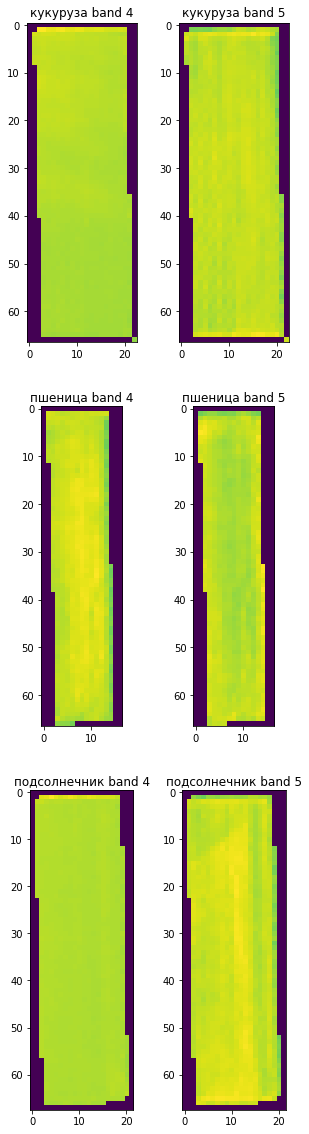

In [28]:
plt.figure(figsize=(5,20))
plt.subplot(321)
plt.imshow(masked_04_20[0].data[0])
plt.title('кукуруза band 4')
plt.subplot(322)
plt.imshow(masked_05_20[0].data[0])
plt.title('кукуруза band 5')
plt.subplot(323)
plt.imshow(masked_04_17[0].data[0])
plt.title('пшеница band 4')
plt.subplot(324)
plt.imshow(masked_05_17[0].data[0])
plt.title('пшеница band 5')
plt.subplot(325)
plt.imshow(masked_04_23[0].data[0])
plt.title('подсолнечник band 4')
plt.subplot(326)
plt.imshow(masked_05_23[0].data[0])
plt.title('подсолнечник band 5')
plt.show()

In [20]:
root = '/Users/vasilii/Desktop/landsat/'
for folder in next(os.walk(root))[1]:
    date = folder.split('_')[3]

    band_04 = rasterio.open(root+folder+'/'+folder+'_B4.TIF')
    band_05 = rasterio.open(root+folder+'/'+folder+'_B5.TIF')
    
    for field_name in field_names:
        masked_04 = mask(band_04, fields[field_name], nodata=0, crop=True)
        masked_05 = mask(band_05, fields[field_name], nodata=0, crop=True)

        field_04 = masked_04[0].data[0].astype('int16')
        field_05 = masked_05[0].data[0].astype('int16')

        field_04 = field_04[np.nonzero(field_04)]
        field_05 = field_05[np.nonzero(field_05)]
        
        ndvis[field_name][datetime.datetime.strptime(date, '%Y%m%d').date()] = np.mean((field_05-field_04)/
                                                                                         (field_05+field_04))
    
    band_04.close()
    band_05.close()

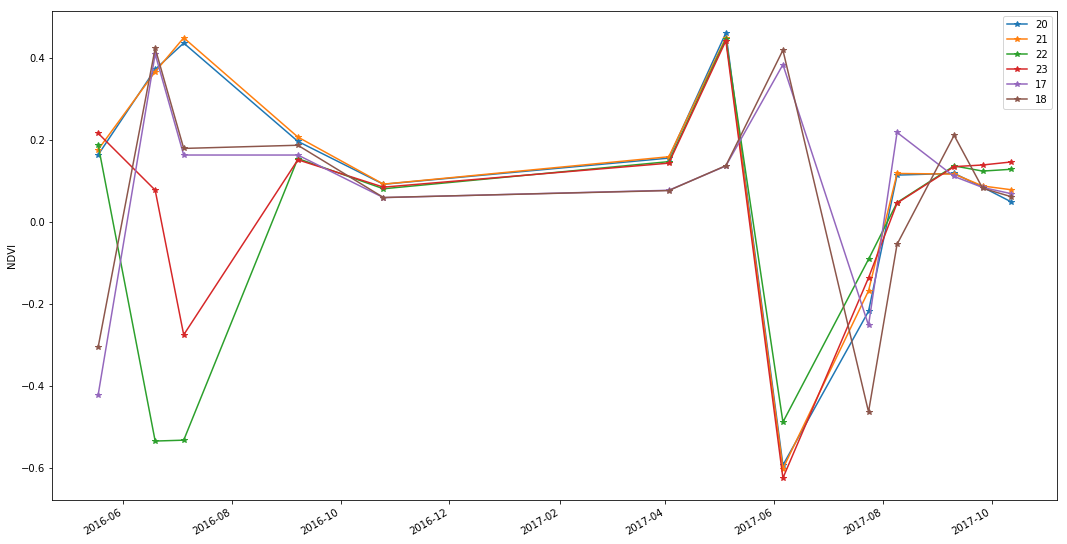

In [22]:
plt.figure(figsize=(18,10))
for field_name in field_names:
    plt.plot(sorted(ndvis[field_name]), [ndvis[field_name][date] for date in sorted(ndvis[field_name])],
             '*-', label=field_name)
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel('NDVI')
plt.show()

In [23]:
print('date', end='\t\t')
for field_name in field_names:
    print('F.', field_name, end='\t')
print()
for date in sorted(ndvis[field_name]):
    print(date, end='\t')
    for field_name in field_names:
        print('%.3f' % round(ndvis[field_name][date], 3), end='\t')
    print()

date		F. 20	F. 21	F. 22	F. 23	F. 17	F. 18	
2016-05-18	0.164	0.176	0.188	0.216	-0.422	-0.305	
2016-06-19	0.372	0.366	-0.534	0.078	0.409	0.423	
2016-07-05	0.436	0.449	-0.532	-0.275	0.163	0.179	
2016-09-07	0.196	0.207	0.155	0.152	0.163	0.187	
2016-10-25	0.092	0.092	0.081	0.085	0.059	0.060	
2017-04-03	0.156	0.159	0.147	0.143	0.077	0.077	
2017-05-05	0.461	0.449	0.446	0.441	0.137	0.137	
2017-06-06	-0.592	-0.601	-0.488	-0.624	0.383	0.419	
2017-07-24	-0.218	-0.168	-0.091	-0.136	-0.252	-0.463	
2017-08-09	0.114	0.118	0.047	0.046	0.218	-0.054	
2017-09-10	0.118	0.117	0.137	0.135	0.111	0.211	
2017-09-26	0.085	0.088	0.124	0.139	0.084	0.082	
2017-10-12	0.049	0.079	0.128	0.146	0.069	0.062	


# Landsat 8 (Top of Atmosphere Reflectance)

In [71]:
root = '/Users/vasilii/Desktop/landsat/'
for folder in next(os.walk(root))[1]:
    date = folder.split('_')[3]

    band_04 = rasterio.open(root+folder+'/'+folder+'_B4.TIF')
    band_05 = rasterio.open(root+folder+'/'+folder+'_B5.TIF')
    meta = open(root+folder+'/'+folder+'_MTL.txt')
    meta = meta.read()
    
    mult_04 = float(re.findall('REFLECTANCE_MULT_BAND_4 = (.+)\n', meta)[0])
    mult_05 = float(re.findall('REFLECTANCE_MULT_BAND_5 = (.+)\n', meta)[0])

    add_04 = float(re.findall('REFLECTANCE_ADD_BAND_4 = (.+)\n', meta)[0])
    add_05 = float(re.findall('REFLECTANCE_ADD_BAND_5 = (.+)\n', meta)[0])
    
    for field_name in field_names:
        masked_04 = mask(band_04, fields[field_name], nodata=0, crop=True)
        masked_05 = mask(band_05, fields[field_name], nodata=0, crop=True)

        field_04 = masked_04[0].data[0].astype('int16')
        field_05 = masked_05[0].data[0].astype('int16')

        field_04 = field_04[np.nonzero(field_04)]
        field_05 = field_05[np.nonzero(field_05)]
        
        field_04 = field_04 * mult_04 + add_04
        field_05 = field_05 * mult_05 + add_05
        
        ndvis[field_name][datetime.datetime.strptime(date, '%Y%m%d').date()] = np.mean((field_05-field_04)/
                                                                                         (field_05+field_04))
    
    band_04.close()
    band_05.close()

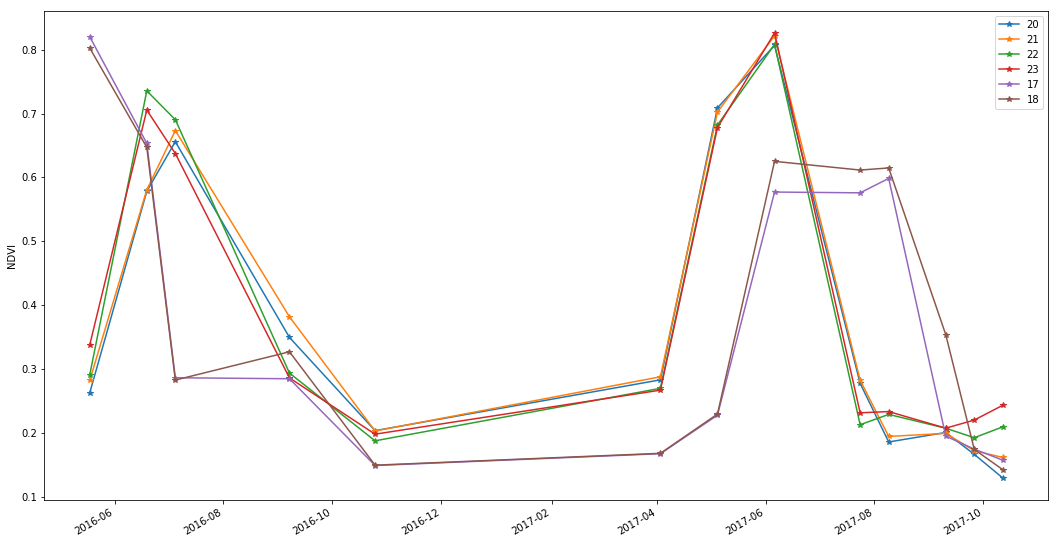

In [72]:
plt.figure(figsize=(18,10))
for field_name in field_names:
    plt.plot(sorted(ndvis[field_name]), [ndvis[field_name][date] for date in sorted(ndvis[field_name])],
             '*-', label=field_name)
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel('NDVI')
plt.show()

In [73]:
print('date', end='\t\t')
for field_name in field_names:
    print('F.', field_name, end='\t')
print()
for date in sorted(ndvis[field_name]):
    print(date, end='\t')
    for field_name in field_names:
        print('%.3f' % round(ndvis[field_name][date], 3), end='\t')
    print()

date		F. 20	F. 21	F. 22	F. 23	F. 17	F. 18	
2016-05-18	0.263	0.282	0.291	0.338	0.820	0.803	
2016-06-19	0.578	0.581	0.736	0.706	0.653	0.647	
2016-07-05	0.656	0.673	0.690	0.637	0.286	0.283	
2016-09-07	0.349	0.382	0.294	0.286	0.285	0.327	
2016-10-25	0.204	0.203	0.188	0.198	0.149	0.149	
2017-04-03	0.283	0.288	0.270	0.267	0.167	0.168	
2017-05-05	0.709	0.703	0.682	0.678	0.228	0.229	
2017-06-06	0.807	0.822	0.808	0.826	0.577	0.625	
2017-07-24	0.277	0.282	0.213	0.231	0.576	0.612	
2017-08-09	0.186	0.194	0.229	0.233	0.598	0.615	
2017-09-10	0.201	0.199	0.207	0.207	0.195	0.354	
2017-09-26	0.166	0.172	0.192	0.220	0.175	0.174	
2017-10-12	0.129	0.162	0.209	0.243	0.157	0.142	
